# General Use

## Find the difference between two DICOM files

In [1]:
import difflib
import pydicom
import tabulate
import sys
import glob
import os

from pydicom.data import get_testdata_file
from pydicom.valuerep import PersonNameUnicode
from pydicom import dcmread, dcmwrite
from pydicom.filebase import DicomFileLike
from pydicom.waveforms import generate_multiplex

from pprint import pprint
from pathlib import Path
from io import BytesIO
from ipytree import Tree, Node
import matplotlib.pylab as plt
import numpy as np

from IPython.display import display, HTML, FileLink

In [2]:
filename_mr = get_testdata_file('MR_small.dcm')
filename_ct = get_testdata_file('CT_small.dcm')

datasets = tuple([pydicom.dcmread(filename, force=True) for filename in (filename_mr, filename_ct)])

# Reference of pydicom.dataset.filedataset
#   https://pydicom.github.io/pydicom/dev/reference/generated/pydicom.dataset.FileDataset.html
for data in datasets:
    print(f'############ {data.filename} ############')
    pprint({k:v for k,v in data.to_json_dict().items() if k.startswith('0008')})

############ /Users/painflat/.local/share/virtualenvs/DICOM--xoABAxb/lib/python3.9/site-packages/pydicom/data/test_files/MR_small.dcm ############
{'00080008': {'Value': ['DERIVED', 'SECONDARY', 'OTHER'], 'vr': 'CS'},
 '00080012': {'Value': ['20040826'], 'vr': 'DA'},
 '00080013': {'Value': ['185434'], 'vr': 'TM'},
 '00080014': {'Value': ['1.3.6.1.4.1.5962.3'], 'vr': 'UI'},
 '00080016': {'Value': ['1.2.840.10008.5.1.4.1.1.4'], 'vr': 'UI'},
 '00080018': {'Value': ['1.3.6.1.4.1.5962.1.1.4.1.1.20040826185059.5457'],
              'vr': 'UI'},
 '00080020': {'Value': ['20040826'], 'vr': 'DA'},
 '00080021': {'vr': 'DA'},
 '00080022': {'vr': 'DA'},
 '00080030': {'Value': ['185059'], 'vr': 'TM'},
 '00080031': {'vr': 'TM'},
 '00080032': {'vr': 'TM'},
 '00080050': {'vr': 'SH'},
 '00080060': {'Value': ['MR'], 'vr': 'CS'},
 '00080070': {'Value': ['TOSHIBA_MEC'], 'vr': 'LO'},
 '00080080': {'Value': ['TOSHIBA'], 'vr': 'LO'},
 '00080090': {'vr': 'PN'},
 '00080201': {'Value': ['-0400'], 'vr': 'SH'},
 '

rep = []
for dataset in datasets:
    lines = str(dataset).split("\n")
    lines = [line + "\n" for line in lines]  # add the newline to end
    rep.append(lines)


html_diff = difflib.HtmlDiff().make_file(rep[0], rep[1])
Path('diff.html').write_text(html_diff)
FileLink('diff.html')

## Display unicode person names

In [3]:
default_encoding = 'iso8859'

person_names = [
    PersonNameUnicode(
        b"Yamada^Tarou=\033$B;3ED\033(B^\033$BB@O:"
        b"\033(B=\033$B$d$^$@\033(B^\033$B$?$m$&\033(B",
        [default_encoding, 'iso2022_jp']),  # DICOM standard 2008-PS3.5 H.3 p98
    PersonNameUnicode(
        b"Wang^XiaoDong=\xcd\xf5\x5e\xd0\xa1\xb6\xab=",
        [default_encoding, 'GB18030']),  # DICOM standard 2008-PS3.5 J.3 p 105
    PersonNameUnicode(
        b"Wang^XiaoDong=\xe7\x8e\x8b\x5e\xe5\xb0\x8f\xe6\x9d\xb1=",
        [default_encoding, 'UTF-8']),  # DICOM standard 2008-PS3.5 J.1 p 104
    PersonNameUnicode(
        b"Hong^Gildong=\033$)C\373\363^\033$)C\321\316\324\327="
        b"\033$)C\310\253^\033$)C\261\346\265\277",
        [default_encoding, 'euc_kr']),  # DICOM standard 2008-PS3.5 I.2 p 101
]


data = []
for name in person_names:
    data.append([name.encodings[1], name.decode(name.encodings[1])])

table = tabulate.tabulate(data, headers=['Encode', 'Name'], tablefmt='html')
display(HTML(table))
    

Encode,Name
iso2022_jp,Yamada^Tarou=山田^太郎=やまだ^たろう
GB18030,Wang^XiaoDong=王^小东
UTF-8,Wang^XiaoDong=王^小東
euc_kr,Hong^Gildong=洪^吉洞=홍^길동


## Show working with memory-based dataset

In [4]:
def write_dataset_to_bytes(dataset):
    with BytesIO() as buffer:
        memory_dataset = DicomFileLike(buffer) # file like object
        dcmwrite(memory_dataset, dataset)
        memory_dataset.seek(0)
        return memory_dataset.read() # return data in bytes


def adapt_dataset_from_bytes(blob):
    dataset = dcmread(BytesIO(blob))
    dataset.is_little_endian = False
    dataset.PatientName = 'Bond^James'
    dataset.PatientID = '007'
    return dataset


class DummyDataBase:
    def __init__(self):
        self._blobs = {}

    def save(self, name, blob):
        self._blobs[name] = blob

    def load(self, name):
        return self._blobs.get(name)

    
file_path = get_testdata_file('CT_small.dcm')
db = DummyDataBase()

dataset = dcmread(file_path)

ds_bytes = write_dataset_to_bytes(dataset)
print(type(ds_bytes))
print(ds_bytes[:100])
db.save('dataset', ds_bytes)

read_bytes = db.load('dataset')
read_dataset = adapt_dataset_from_bytes(read_bytes)
print(type(read_dataset))
print(str(read_dataset)[:100])


<class 'bytes'>
b'II*\x00T\x18\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
<class 'pydicom.dataset.FileDataset'>
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  U


## Show a dicom file using hierarchical tree

In [5]:
file_path = get_testdata_file('CT_small.dcm')
ds = pydicom.dcmread(file_path)
ds.decode()


def recurse_tree(tree, dataset, parent_node, hide):
    for data in dataset:
        node = Node(str(data))
        parent_node.add_node(node)
            
        if data.VR == "SQ":
            node.opened = False
            for idx , ds in enumerate(data.value):
                description = data.name.replace("Sequence", "")
                node_name = f"{description}-{idx+1}"
                node.add_node(Node(node_name))
                recurse_tree(tree, ds, node, True)


tree = Tree()
root_node = Node("root")
root_node.opened = False
recurse_tree(tree, ds, root_node, False)
tree.add_node(root_node)
tree

Tree(nodes=(Node(name='root', nodes=(Node(name="(0008, 0005) Specific Character Set              CS: 'ISO_IR 1…

# Image Processing

## Downsize MRI image using pydicom

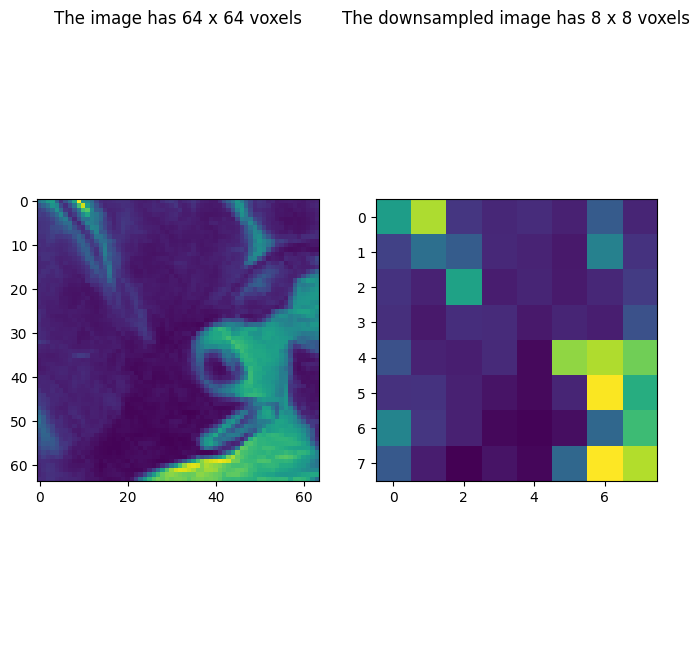

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))


filename = get_testdata_file('MR_small.dcm')
ds = pydicom.dcmread(filename)


data = ds.pixel_array
ax[0].set_title(f'The image has {data.shape[0]} x {data.shape[1]} voxels')
ax[0].axis('off')
fig.add_subplot(1, 2, 1)
plt.imshow(ds.pixel_array)


data_downsampling = data[::8, ::8]
ds.PixelData = data_downsampling.tobytes()
ds.Rows, ds.Columns = data_downsampling.shape
ax[1].set_title(f'The downsampled image has {data_downsampling.shape[0]} x {data_downsampling.shape[1]} voxels')
ax[1].axis('off')
fig.add_subplot(1, 2, 2)
plt.imshow(ds.pixel_array)


plt.show()

## Decode and plot Waveform Data

nr_channels: 12, nr_samples: 10000, sampling_fq: 1000
numpy shape: (10000,)
nr_channels: 12, nr_samples: 1200, sampling_fq: 1000
numpy shape: (1200,)


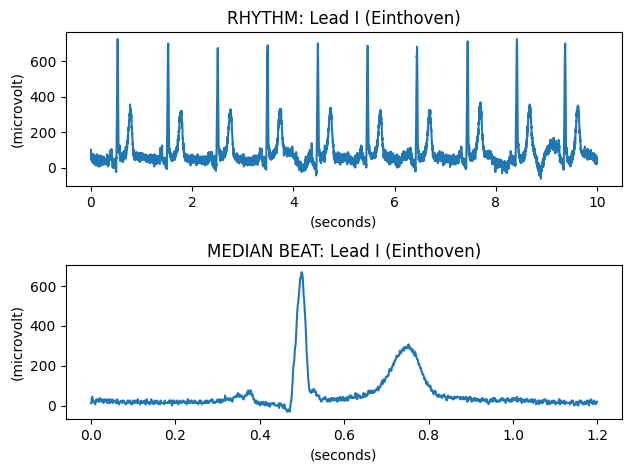

In [7]:
fpath = get_testdata_file("waveform_ecg.dcm")
ds = dcmread(fpath)


ch_idx = 0
fig, axes = plt.subplots(len(ds.WaveformSequence))
generator = generate_multiplex(ds, as_raw=False)


for ax, mplx, arr in zip(axes, ds.WaveformSequence, generator):
    nr_channels = mplx.NumberOfWaveformChannels
    nr_samples = mplx.NumberOfWaveformSamples
    sampling_fq = mplx.SamplingFrequency  # in Hz
    mplx_label = mplx.MultiplexGroupLabel
    ch_item = mplx.ChannelDefinitionSequence[ch_idx]

    x = np.arange(0, nr_samples / sampling_fq, 1 / sampling_fq)
    x_units = "seconds"
    
    print(f'nr_channels: {nr_channels}, nr_samples: {nr_samples}, sampling_fq: {sampling_fq}')
    print(f'numpy shape: {x.shape}')

    if "ChannelSensitivityUnitsSequence" in ch_item:
        y_units = ch_item.ChannelSensitivityUnitsSequence[0].CodeMeaning
    else:
        y_units = "unitless"

    ch_source = ch_item.ChannelSourceSequence[0].CodeMeaning

    ax.plot(x, arr[..., ch_idx])
    ax.set_title(f"{mplx_label}: {ch_source}")
    ax.set_xlabel(f"({x_units})")
    ax.set_ylabel(f"({y_units})")


fig.tight_layout(pad=1)
plt.show()

## Load CT slices and plot axial, sagittal and coronal images (finding data source)

If you don't have any data source, please find it on TCIA.
The following link may be helpful!!
- https://www.kaggle.com/code/redwankarimsony/ct-scans-dicom-files-windowing-explained/notebook
- https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=89096268
- https://wiki.cancerimagingarchive.net/display/NBIA/Downloading+TCIA+Images#DownloadingTCIAImages-DownloadingtheNBIADataRetriever

In [ ]:
ctr, num, target_dict = 0, 0, {}
for root, dirs, files in os.walk('./data'):
    for file in files:
        num += 1
        if 'dcm' in file:
            ds = pydicom.dcmread(f'{root}/{file}')
            if hasattr(ds, 'SliceLocation'):
                ctr += 1
                if root not in target_dict:
                    target_dict[root] = []
                target_dict[root].append(file)

print(f'######## From {num} files found {ctr} DCM with SliceLocation ########')
for key in target_dict:
    if len(target_dict[key]) > 2:
        print(f'{key} {len(target_dict[key])}')

In [ ]:
# load the DICOM files
files = []
key = './data/manifest-1669817128730/Colorectal-Liver-Metastases/CRLM-CT-1055/10-05-1994-NA-CT ANGIO LIVER WITH CHPEL-85384/101.000000-Bind24514171..390-02696'
for file_path in target_dict[key]:
    for fname in glob.glob(f'{key}/{file_path}', recursive=False):
        # print("loading: {}".format(fname))
        files.append(pydicom.dcmread(fname))

print("file count: {}".format(len(files)))

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)
print(len(slices))

idx = 0

# pixel aspects, assuming all slices are the same
ps = slices[idx].PixelSpacing
ss = slices[idx].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

# create 3D array
img_shape = list(slices[idx].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

# plot 3 orthogonal slices
a1 = plt.subplot(2, 2, 1)
plt.imshow(img3d[:, :, img_shape[2]//2])
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d[:, img_shape[1]//2, :])
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 3)
plt.imshow(img3d[img_shape[0]//2, :, :].T)
a3.set_aspect(cor_aspect)

plt.show()

# Input & Output

# Metadata Processing

# DICOM Network Protocol

# Introduction of Orthanc